In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
words = open('names.txt', 'r').read().splitlines()

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [14]:
# build the dataset

def build_dataset(words):
    # block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1]) # first 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # next 10%
Xte, Yte = build_dataset(words[n2:]) # last 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
# MLP
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number ofn eurons in the hidden layer of the MLP
block_size = 3 # the number of characters to be considered in the context window

g = torch.Generator().manual_seed(2147483647) # for reproducability
context_window_size = 5
embedding_size = 12
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) # * 0.3
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1 # initialize to small values
b2 = torch.randn(vocab_size,                      generator=g) * 0 # initialize to 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnvar_running = torch.ones((1, n_hidden))

# parameters = [C, W1, b1, W2, b2, bngain, bnbias]

# for p in parameters:
#   p.requires_grad = True

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [22]:
lossi = []
stepi = []

In [23]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,)) # gradient is worse, but faster
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch normalization (mean 0, std 1)
  
  # Update not using gradient descent
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # update in direction of batch mean
    bnvar_running = 0.999 * bnvar_running + 0.001 * bnstdi # update in direction of batch std
  
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad= None
  loss.backward() # calculate gradients w.r.t. loss

  # update

  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad # update neurons based on gradient

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'"{i:7d}/ {max_steps}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  # break


"      0/ 200000: 3.5331
"  10000/ 200000: 2.5171
"  20000/ 200000: 2.3249
"  30000/ 200000: 2.3522
"  40000/ 200000: 2.0470
"  50000/ 200000: 2.1029
"  60000/ 200000: 2.2419
"  70000/ 200000: 2.2972
"  80000/ 200000: 2.0534
"  90000/ 200000: 2.1352
" 100000/ 200000: 2.4603
" 110000/ 200000: 1.8063
" 120000/ 200000: 1.9050
" 130000/ 200000: 1.9084
" 140000/ 200000: 2.1692
" 150000/ 200000: 2.0104
" 160000/ 200000: 1.9730
" 170000/ 200000: 1.8871
" 180000/ 200000: 1.8456
" 190000/ 200000: 2.3960


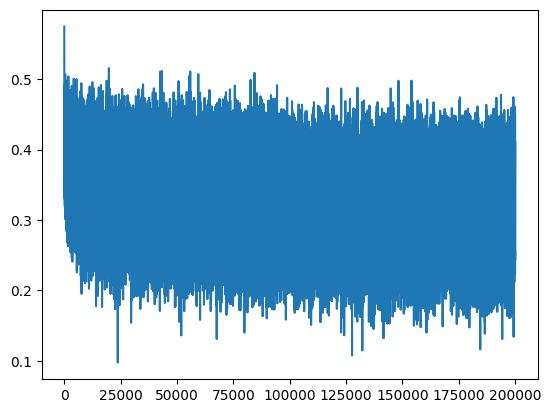

In [17]:
plt.plot(lossi)

In [19]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # measure the mean/std over the enitre training set
    bnmean = hpreact.mean(0,keepdim=True)
    bnstd = hpreact.std(0,keepdim=True)


In [18]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # batch normalization (mean 0, std 1)
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.0692989826202393
dev 2.112251043319702


In [ ]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range (20):

    out = []
    context = [0] * 3
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmah.
amelle.
khyim.
shreety.
skanss.
emmahnee.
deliah.
jareen.
nellara.
chaiiven.
legn.
dham.
pori.
quint.
suline.
liven.
coriell.
dearisi.
jace.
pirra.


What loss do we expect at initialization?

We expect a 1/27 probability for each character.
Logits are way too high/ low at initialization.
The network spends the first couple iterations squashing down the weights dramatically, which prevents actual learning.

To prevent this, we initialize the weights to be closer to 0.

This reduces the network to focus on squashing weights during early training iterations, because they are  closer to what the actual predictions should look like. If we have 27 possible predictions, we expect the loss to be around -log(softmax) of the 27 logits.

Furthermore, we can prevent "dead" neurons by fixing the saturation problem in our activation layer.

When values are close to -1 or 1, tanh will return 0, which kills gradients during backpropagation through the network.
This can kill neurons, as they will have 0 gradients and will not learn anything. To combat this, we want tanh initialization to be closer to 0. Extreme values of tanh cause the neurons to reaach the flat regions, in which there is little activation. Activation is highest at 0.

During backpropagation, gradients that flow through these neurons will get multiplied by a small derivative, which can kill the neurons.

# Why use batch normalization?
Use batch norm to control the statistics of activations in the neural net.
It is common to sprinkle batch normalization layers throughout the neural net, often place it after layers that have
multiplications (linear layer/ convolutional layer).

Batch normalization internally has parameters for gain and bias (trained using backpropagation).
It also have two buffers: running mean and running standard deviation (not trained using backpropagation).

It's calculating the mean and std of activation of layers feeding into batchnorm layer, over that batch. Then it centers the batch to be unit gaussian, then it's offsetting and scaling it by the learned bias and gain. It keeps track of mean and std of the inputs, and its maintaining running mean and std. 

This will be used at inference so we don't need to re-estimate mean and std all the time. So that allows us to forward individual examples at test time.

In [ ]:
-torch.tensor(1/27.0).log() # expected loss for random guessing

tensor(3.2958)

In [ ]:
# 4-dimensional example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss


(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

# Spelled out in PyTorch

In [17]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [18]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain+_graph
    for p in parameters:
        p.grad = None
    loss.backward() # calculate gradients w.r.t. loss

    # update
    lr = 0.1 if i < 100000 else -0.1 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break # AFTER_DEBUG: would take out to run full optimization

      0/200000: 3.2870


layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 3.69%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.59%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.66%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.78%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.72%


Text(0.5, 1.0, 'activation distribution')

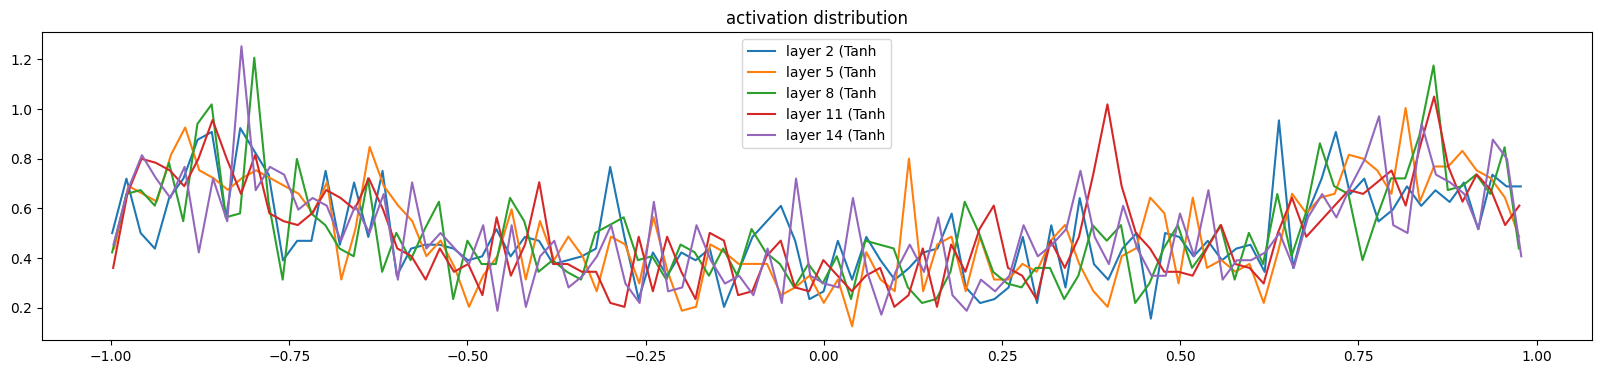

In [22]:

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')